In [1]:
import matplotlib.pyplot as plt
from vessel_models import VesselModel
import numpy as np
import os
import cyipopt as ipopt

In [2]:
class MHE:
    def __init__(self, model: VesselModel, N, ns, nu, nc, dt, Qvec, Rvec, Qfvec, Pvec, c0, sref, uref):
        self.model = model
        self.N = N # this is the MPC window size, not the N of the entire trajectory
        self.ns = ns
        self.nu = nu
        self.nc = nc # number of hydrodynamic coefficients (default 13) + however many tweak variables
        self.dt = dt

        self.Qvec = Qvec
        
        self.Rvec = Rvec
        self.Qfvec = Qfvec
        self.Pvec = Pvec
        self.Q = np.diag(Qvec)
        self.R = np.diag(Rvec)
        self.Qf = np.diag(Qfvec)
        self.P = np.diag(Pvec) # weight matrix for coeff cost (to reduce difference between coefficients each run)

        self.c0 = c0 # initial guess (or warm start) of hydrodynamic coefficients
        self.sref = sref # reference trajectory MPC is following
        self.uref = uref # reference controls for estimated coefficient feed forward

        # coeff clamps
        self.c_min = -100
        self.c_max = 100

        self.Z0 = self.make_initial_guess()
        #assert len(self.Z0) == (N-1)*nc, "Length of initial guess does not match length calculated from given N and nc"

    def make_initial_guess(self):
        #coeff = np.zeros((self.N-1,self.nc))
        #coeff[0] = self.c0
        coeff = self.c0

        coeff_flat = coeff.flatten()
        guess = coeff_flat
        return guess
    
    def flat2vec(self, Z):
        coeff = Z.reshape((self.N-1, self.nc))
        return coeff
    
    def LQRcost_fast(self, Z):
        #coeff = self.flat2vec(Z)
        coeff = Z

        Sfwd = np.zeros((self.N,self.ns))
        Sfwd[0] = self.sref[0]
        for i in range(self.N-1):
            sn = Sfwd[i]
            un = self.uref[i]
            #cn = coeff[i]
            cn = coeff
            Sfwd[i+1] = self.model.extended_rk4(sn, un, cn, self.dt)

        S = Sfwd[:-1]

        cost = 0
        cost += np.sum(0.5 * np.vecdot((S-self.sref[:-1]), np.multiply(self.Qvec, S-self.sref[:-1])))
        cost += np.sum(0.5 * np.vecdot((Sfwd[-1]-self.sref[-1]), np.multiply(self.Qfvec, Sfwd[-1]-self.sref[-1])))
        cost += np.sum(0.5 * np.vecdot((coeff-self.c0), np.multiply(self.Pvec, coeff-self.c0)))
        #print(f"cost from states: {cost}")
        #cost_coeff = np.sum(0.5 * np.vecdot((coeff[1:]-coeff[:-1]), np.multiply(self.Pvec, coeff[1:]-coeff[:-1])))
        #cost_coeff = np.sqrt(np.sum(np.square(coeff)))
        #cost += cost_coeff
        #print(f"cost from coefficients: {cost_coeff}")

        return cost
    
    def inequality_constraints_fast(self, Z):
        coeff = Z

        constraints_min_controls = coeff - self.c_min
        constraints_max_controls = -coeff + self.c_max
        
        constraints = np.concatenate((constraints_min_controls.flatten(), constraints_max_controls.flatten()))

        assert np.all(np.isfinite(constraints)), "NaN or Inf in constraints"
        return np.array(constraints)
    
    def exec_MPC(self):
        constraints = [
            {"type": "ineq", "fun": self.inequality_constraints_fast}
        ]

        self.sol = ipopt.minimize_ipopt(
            fun=self.LQRcost_fast,
            x0=self.Z0,
            constraints=constraints,
            tol=1e-4,
            options={"disp": 5,
                     'linear_solver': 'ma57',
                     'hsllib': f"{os.environ['CONDA_PREFIX']}/lib/x86_64-linux-gnu/libcoinhsl.so"}
        )

In [3]:
# Simulation variables
N = 100
dt = 0.1
ns = 6
nu = 3
nc = 16 + 6 # hydrodynamic coefficients + 6 tweak factors

N_mpc = 10

# Cost matrices
Qvec = 3*np.ones(ns)
Rvec = np.ones(nu)
Qfvec = 10*np.ones(ns)
Pvec = 0.3*np.ones(nc)

# Reference trajectory and inputs
Sload = np.loadtxt('dircol_soln.csv', delimiter=',')
#Sload = np.loadtxt('gen_soln_current_mismatch.csv', delimiter=',')
Uload = np.loadtxt('dircol_inpu.csv', delimiter=',')

model = VesselModel()

In [4]:
Sfwd = np.zeros((N, ns))
Sfwd[0] = Sload[N_mpc-1]

c_init = np.zeros(nc)
c_init[-9:-6] = [23.8, 1.76, 0.046] # warm start with measured mass values
C = np.tile(c_init, (N-1, 1))
#C = np.zeros((N-1, nc))

for i in range(N_mpc, N):
    sref = Sload[i-N_mpc:i]
    uref = Uload[i-N_mpc:i-1]
    un = Uload[i-1]
    sn = Sload[i-1]
    c0 = C[i-N_mpc]
    optimizer = MHE(model, N_mpc, ns, nu, nc, dt, Qvec, Rvec, Qfvec, Pvec, c0, sref, uref)
    optimizer.exec_MPC()
    C[i-N_mpc+1] = optimizer.sol.x
    Sfwd[i] = model.extended_rk4(sn, un, C[i-N_mpc], dt)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      968
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       22
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constrai

[[25.70174571 25.73048936 25.73146791 ... 25.70174571 25.70174571
  25.70174571]
 [25.73048936 25.76496287 25.76599212 ... 25.73048936 25.73048936
  25.73048936]
 [25.73146791 25.76599212 25.76707007 ... 25.73146791 25.73146791
  25.73146791]
 ...
 [25.70174571 25.73048936 25.73146791 ... 25.70174571 25.70174571
  25.70174571]
 [25.70174571 25.73048936 25.73146791 ... 25.70174571 25.70174571
  25.70174571]
 [25.70174571 25.73048936 25.73146791 ... 25.70174571 25.70174571
  25.70174571]]


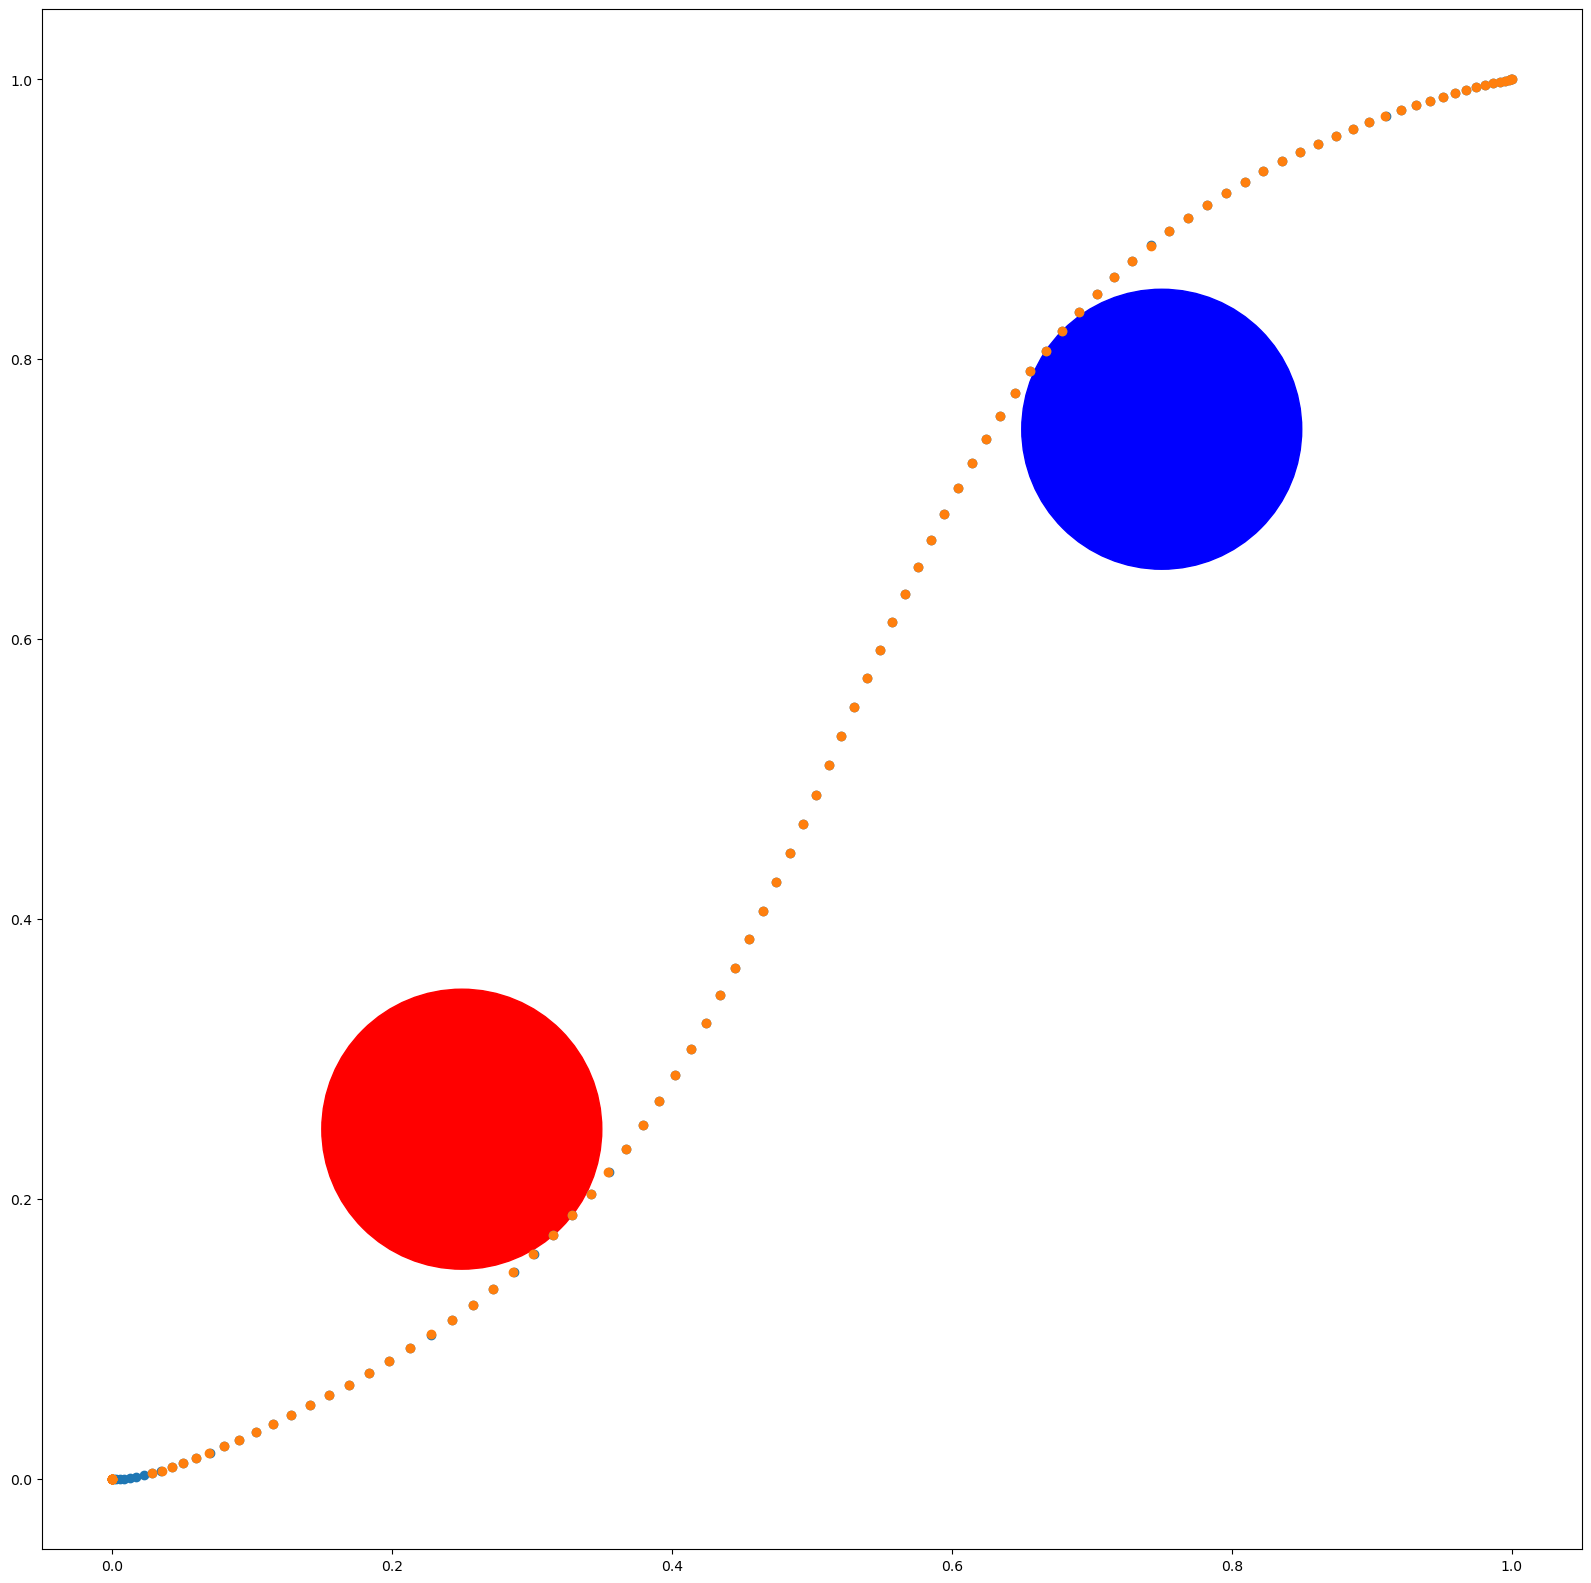

In [5]:
print(np.cov(C))
np.savetxt("coeff.csv", C, delimiter=",")

ps = Sfwd.T
ps_ref = Sload.T
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
circle1 = plt.Circle((0.25, 0.25), 0.1, color='r')
circle2 = plt.Circle((0.3, 0.8), 0.25, color='g')
circle3 = plt.Circle((0.75, 0.75), 0.1, color='b')
circle4 = plt.Circle((0.8, 0.3), 0.25, color='y')
axes.add_patch(circle1)
#axes.add_patch(circle2)
axes.add_patch(circle3)
#axes.add_patch(circle4)
axes.scatter(ps_ref[1], ps_ref[0])
axes.scatter(ps[1], ps[0])
axes.set_aspect('equal', adjustable='box')
plt.show()

In [6]:
C_soln = np.zeros(nc)
start = 10
sref = Sload[start:start+N_mpc]
uref = Uload[start:start+N_mpc-1]
c0 = np.zeros(nc)
#c0 = np.array(list(model.params.values()))[:-3] + np.random.rand(nc)*5
print(c0)
assert len(c0) == nc
optimizer = MHE(model, N_mpc, ns, nu, nc, dt, Qvec, Rvec, Qfvec, Pvec, c0, sref, uref)
optimizer.exec_MPC()
#coeff = optimizer.flat2vec(optimizer.sol.x)
coeff = optimizer.sol.x
coeff_soln = coeff[-1]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
This is Ipopt version 3.14.17, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      968
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       22
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       44
        inequality constraints with only lower bounds:       44
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e

LinAlgError: Singular matrix

-3.816269331598253e-09
[-2.15021883e-05 -3.27609733e-06  1.90237294e-04  1.24166641e-05
  1.86744806e-03 -4.52509628e-03 -4.39249279e-02 -2.42437131e-02
 -6.91717289e-05  3.82593449e-04  1.12031457e-03 -6.78059483e-03
 -4.39527403e-02 -1.39725671e-03 -6.23159478e-03 -1.21015552e-01
 -2.16370215e-10 -3.59855061e-09 -3.81626933e-09]


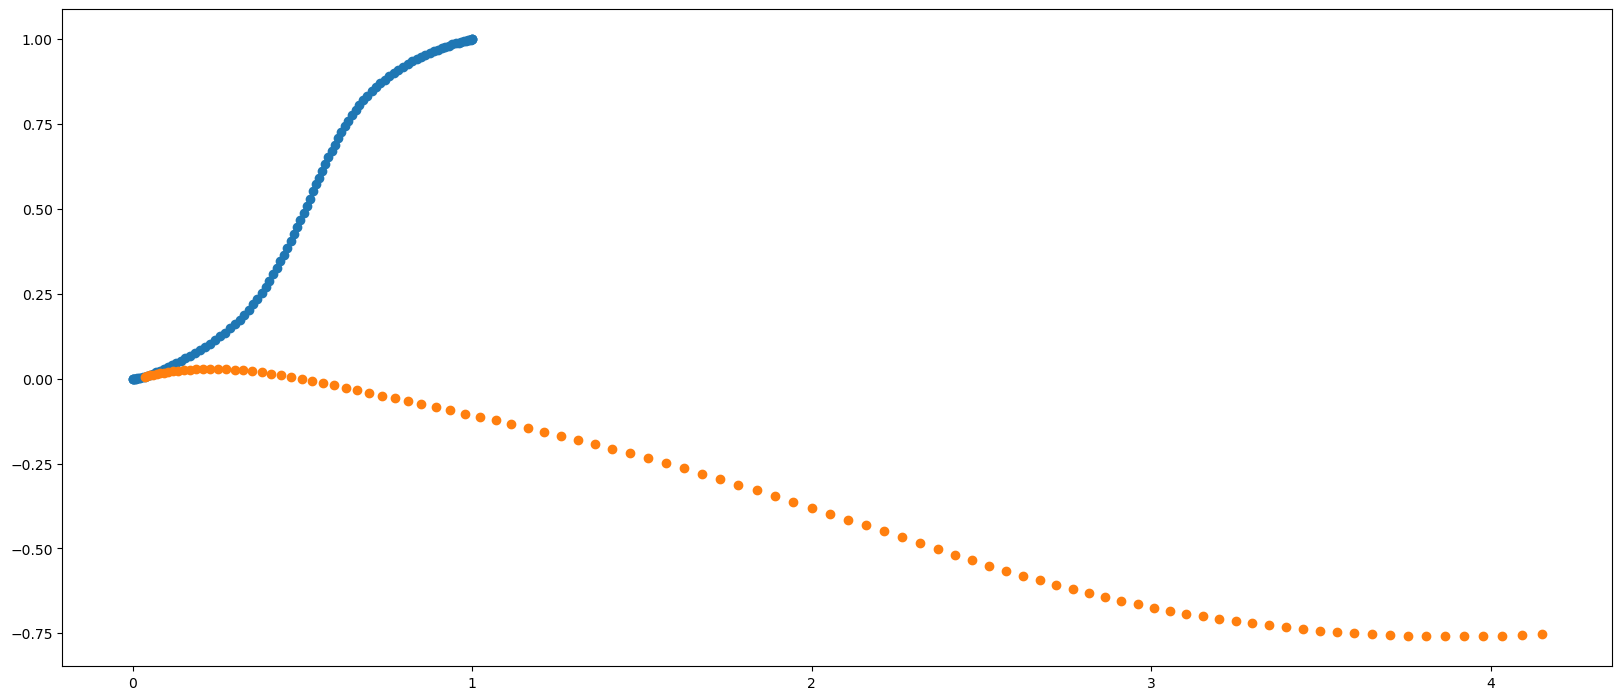

In [ ]:
print(coeff_soln)
print(coeff)

Sfwd = np.zeros((N, ns))
Sfwd[0] = sref[0]
for i in range(N-1):
    sn = Sfwd[i]
    un = Uload[i]
    #cn = coeff[i]
    cn = coeff
    Sfwd[i+1] = model.extended_rk4(sn, un, cn, dt)

ps = Sfwd.T
ps_ref = Sload.T
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
circle1 = plt.Circle((0.25, 0.25), 0.1, color='r')
circle2 = plt.Circle((0.3, 0.8), 0.25, color='g')
circle3 = plt.Circle((0.75, 0.75), 0.1, color='b')
circle4 = plt.Circle((0.8, 0.3), 0.25, color='y')
#axes.add_patch(circle1)
#axes.add_patch(circle2)
#axes.add_patch(circle3)
#axes.add_patch(circle4)
axes.scatter(ps_ref[1], ps_ref[0])
axes.scatter(ps[1], ps[0])
axes.set_aspect('equal', adjustable='box')
plt.show()
